In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the processed data
df = pd.read_csv("processed_data.csv")

print(f"🔮 XGBoost Carbon Intensity Forecasting")
print("="*60)
print(f"Processed data shape: {df.shape}")
print(f"Date range: {df['Datetime_UTC'].min()} to {df['Datetime_UTC'].max()}")

# Check if target column exists
if 'Carbon_intensity_gCO₂eq_kWh_direct' in df.columns:
    print("✅ Target column found!")
else:
    print("❌ Target column missing")

🔮 XGBoost Carbon Intensity Forecasting
Processed data shape: (175320, 25)
Date range: 2021-01-01 00:00:00 to 2024-12-31 23:00:00
✅ Target column found!


In [4]:
# Prepare comprehensive feature set for XGBoost
feature_cols = [
    # Time components
    'Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear',
    
    # Regional information
    'Zone_encoded',
    
    # Energy metrics (already scaled)
    'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%',
    
    # Engineered features
    'Carbon_Efficiency', 'Clean_Energy_Gap',
    
    # Moving averages (trend features)
    'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h'
]

# Add categorical features if they exist (Season, TimeOfDay)
categorical_features = []
for col in df.columns:
    if col.startswith('Season_') or col.startswith('TimeOfDay_'):
        feature_cols.append(col)
        categorical_features.append(col)

# Filter only existing columns
feature_cols = [col for col in feature_cols if col in df.columns]

# Prepare X and y
X = df[feature_cols].fillna(0)
y = df['Carbon_intensity_gCO₂eq_kWh_direct']

print(f"Features used: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Features used: 13
Feature columns: ['Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'Zone_encoded', 'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%', 'Carbon_Efficiency', 'Clean_Energy_Gap', 'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h']
Feature matrix shape: (175320, 13)
Target variable shape: (175320,)


In [5]:
# Time-based train-test split (important for time series)
split_idx = int(0.8 * len(X))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training period: {df['Datetime_UTC'].iloc[:split_idx].min()} to {df['Datetime_UTC'].iloc[:split_idx].max()}")
print(f"Test period: {df['Datetime_UTC'].iloc[split_idx:].min()} to {df['Datetime_UTC'].iloc[split_idx:].max()}")

Training set: (140256, 13)
Test set: (35064, 13)
Training period: 2021-01-01 00:00:00 to 2024-12-31 23:00:00
Test period: 2021-01-01 00:00:00 to 2024-12-31 23:00:00


In [6]:
# XGBoost Model with optimized parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

# Train the model
print("🚀 Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("✅ XGBoost model trained successfully!")

🚀 Training XGBoost model...
✅ XGBoost model trained successfully!


In [7]:
# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate comprehensive metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

# Display results
print("="*60)
print("🌟 XGBOOST REGRESSION - CARBON INTENSITY FORECASTING")
print("="*60)
print(f"Training Metrics:")
print(f"  MAE:  {train_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {train_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Metrics:")
print(f"  MAE:  {test_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {test_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

🌟 XGBOOST REGRESSION - CARBON INTENSITY FORECASTING
Training Metrics:
  MAE:  0.0072 gCO₂eq/kWh
  RMSE: 0.0103 gCO₂eq/kWh
  R²:   0.9999

Test Metrics:
  MAE:  0.0518 gCO₂eq/kWh
  RMSE: 0.0606 gCO₂eq/kWh
  R²:   0.9735


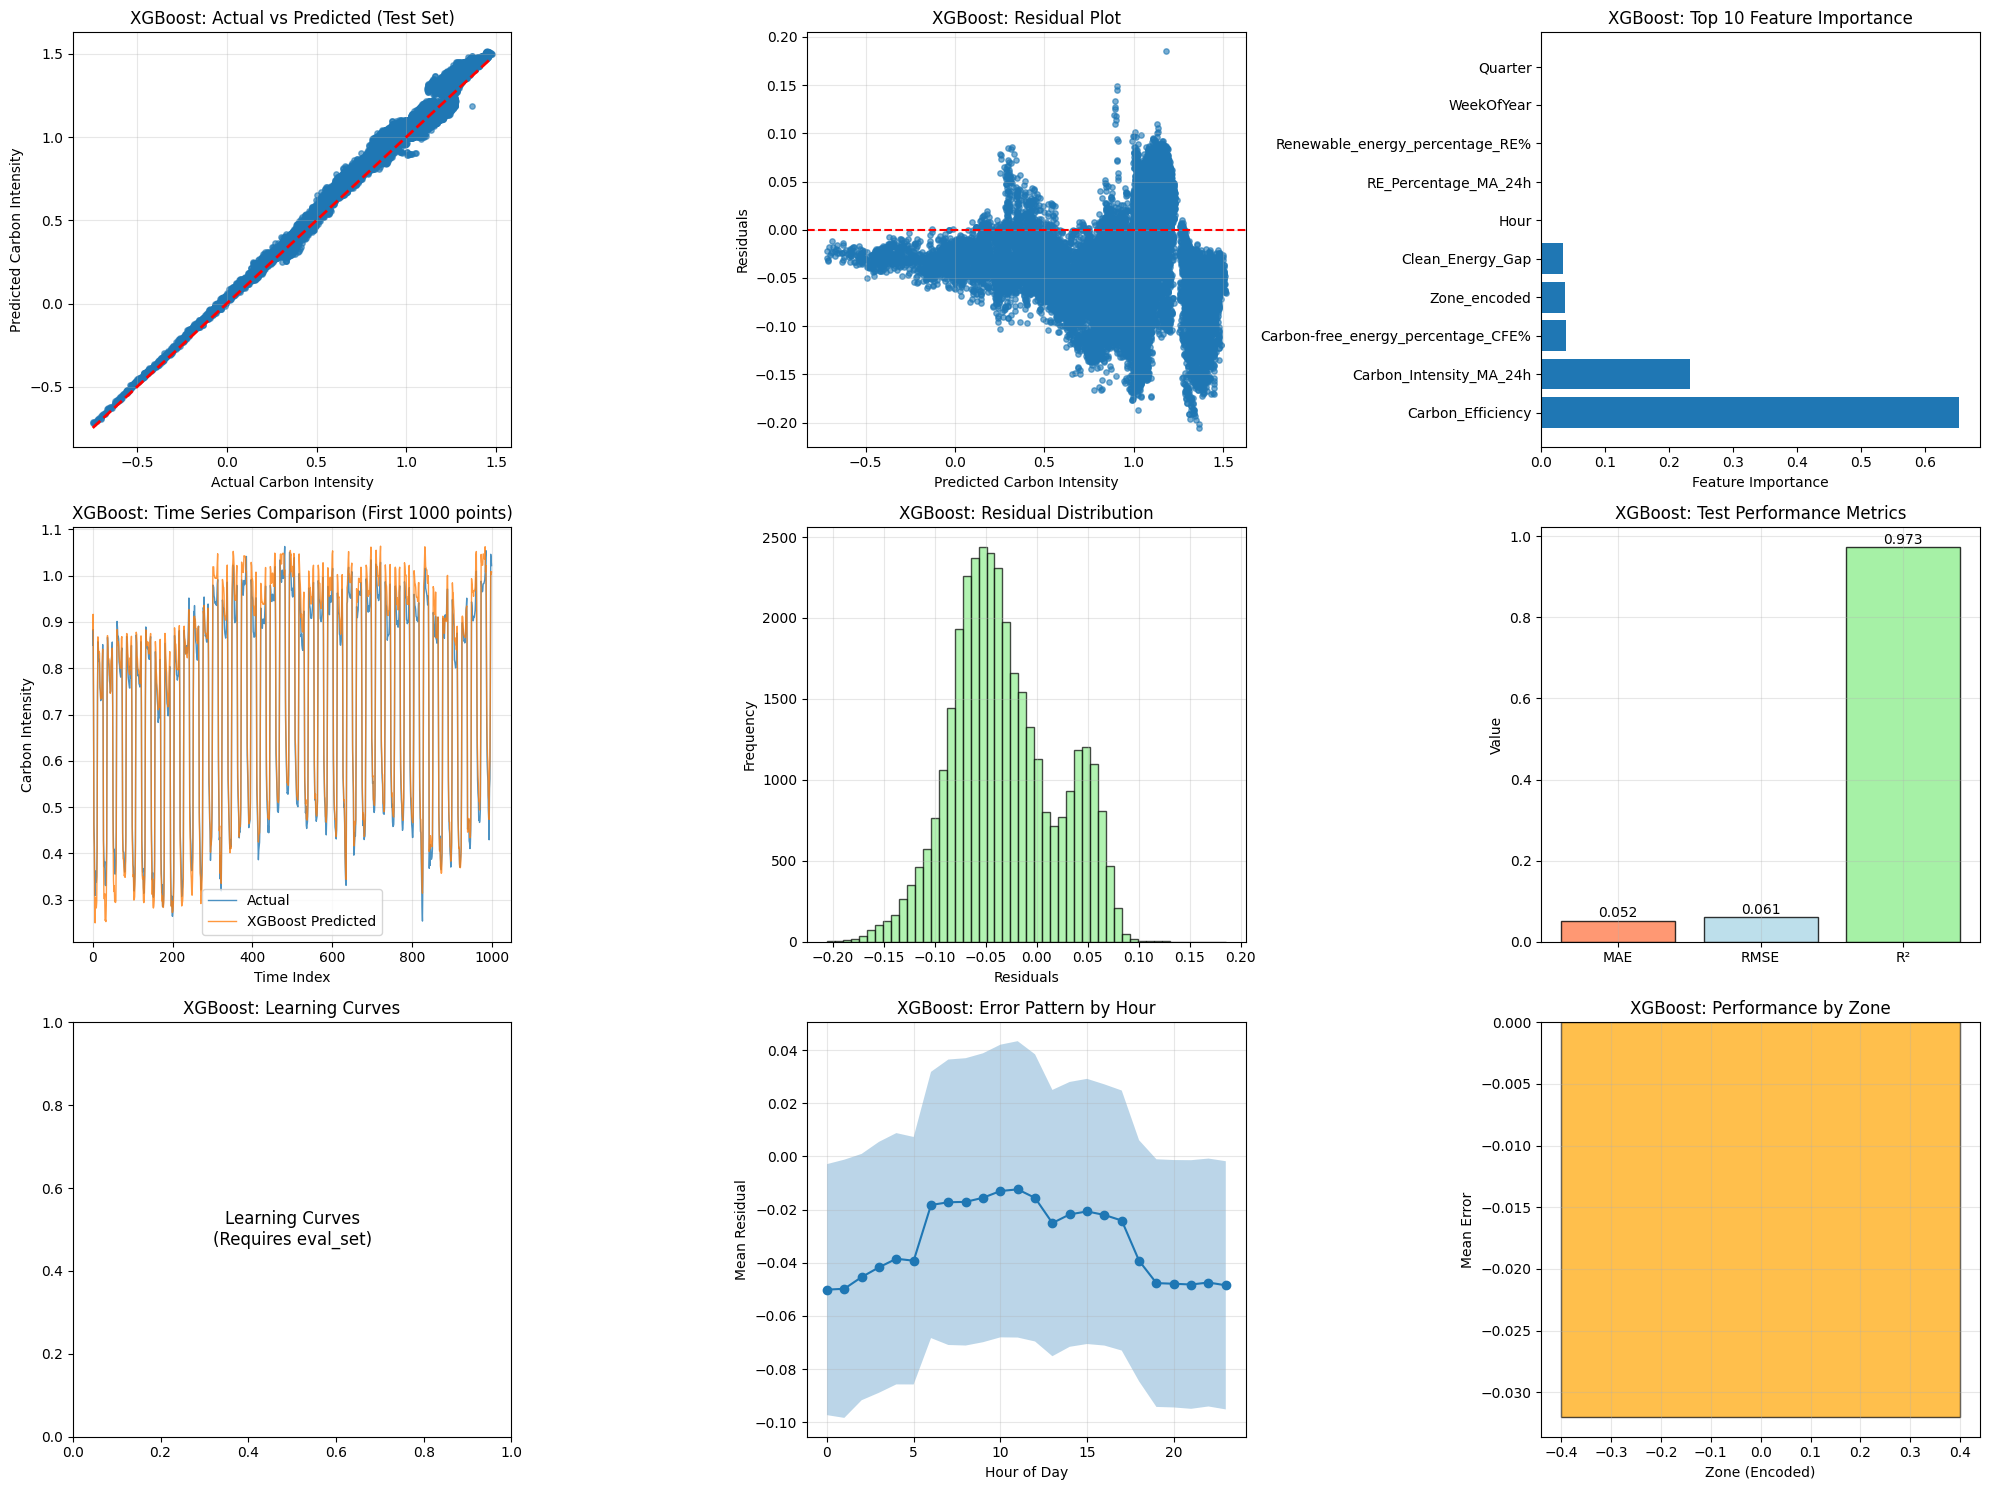

In [8]:
# Comprehensive XGBoost Visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6, s=15)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Carbon Intensity')
axes[0, 0].set_ylabel('Predicted Carbon Intensity')
axes[0, 0].set_title('XGBoost: Actual vs Predicted (Test Set)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.6, s=15)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Carbon Intensity')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('XGBoost: Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (built-in XGBoost)
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

top_features = importance_df.head(10)
axes[0, 2].barh(range(len(top_features)), top_features['importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['feature'])
axes[0, 2].set_xlabel('Feature Importance')
axes[0, 2].set_title('XGBoost: Top 10 Feature Importance')

# 4. Time series comparison (sample)
sample_size = 1000
axes[1, 0].plot(y_test.iloc[:sample_size].values, label='Actual', alpha=0.8, linewidth=1)
axes[1, 0].plot(y_pred_test[:sample_size], label='XGBoost Predicted', alpha=0.8, linewidth=1)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Carbon Intensity')
axes[1, 0].set_title(f'XGBoost: Time Series Comparison (First {sample_size} points)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Error distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('XGBoost: Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance metrics comparison
metrics = ['MAE', 'RMSE', 'R²']
values = [test_mae, test_rmse, test_r2]
colors = ['coral', 'lightblue', 'lightgreen']

bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 2].set_title('XGBoost: Test Performance Metrics')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(True, alpha=0.3)

for bar, value in zip(bars, values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.3f}', ha='center', va='bottom')

# 7. Learning curves (if you want to show training progress)
# This would require saving eval results during training
axes[2, 0].text(0.5, 0.5, 'Learning Curves\n(Requires eval_set)', 
               ha='center', va='center', transform=axes[2, 0].transAxes, fontsize=12)
axes[2, 0].set_title('XGBoost: Learning Curves')

# 8. Prediction error by hour of day
df_test = df.iloc[split_idx:].copy()
df_test['predicted'] = y_pred_test
df_test['residuals'] = residuals

hourly_error = df_test.groupby('Hour')['residuals'].agg(['mean', 'std']).reset_index()
axes[2, 1].plot(hourly_error['Hour'], hourly_error['mean'], marker='o')
axes[2, 1].fill_between(hourly_error['Hour'], 
                       hourly_error['mean'] - hourly_error['std'],
                       hourly_error['mean'] + hourly_error['std'], alpha=0.3)
axes[2, 1].set_xlabel('Hour of Day')
axes[2, 1].set_ylabel('Mean Residual')
axes[2, 1].set_title('XGBoost: Error Pattern by Hour')
axes[2, 1].grid(True, alpha=0.3)

# 9. Zone-wise performance
zone_performance = df_test.groupby('Zone_encoded').agg({
    'residuals': ['mean', 'std', 'count']
}).round(4)
zone_performance.columns = ['Mean_Error', 'Std_Error', 'Count']

axes[2, 2].bar(range(len(zone_performance)), zone_performance['Mean_Error'], 
              alpha=0.7, color='orange', edgecolor='black')
axes[2, 2].set_xlabel('Zone (Encoded)')
axes[2, 2].set_ylabel('Mean Error')
axes[2, 2].set_title('XGBoost: Performance by Zone')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# SHAP Explainability Analysis
print("🔍 Generating SHAP explanations...")

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a sample (for speed)
sample_size = min(1000, len(X_test))
X_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"SHAP analysis completed for {sample_size} samples")

🔍 Generating SHAP explanations...
SHAP analysis completed for 1000 samples


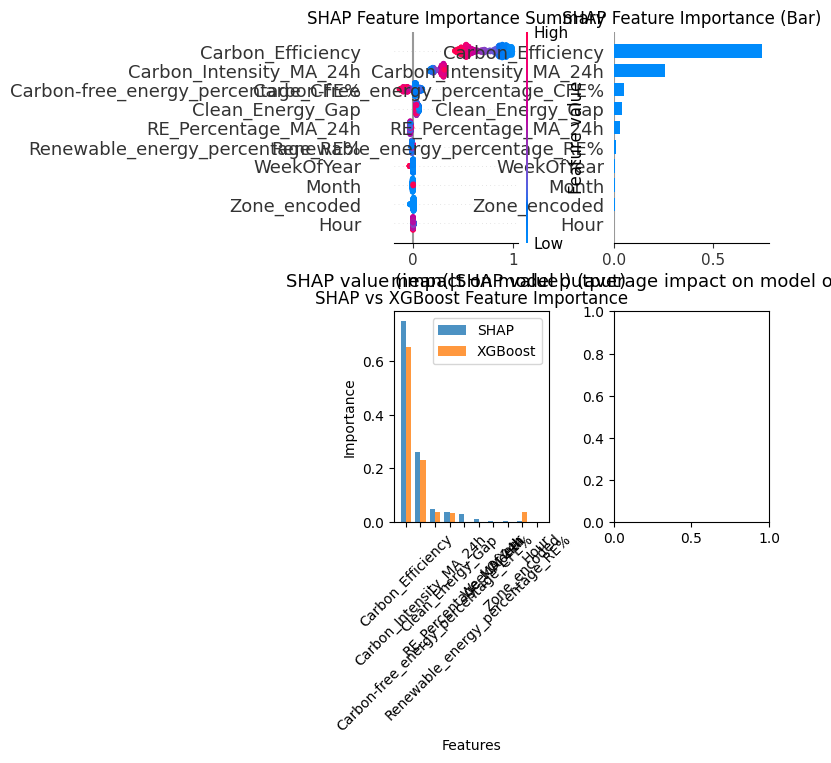

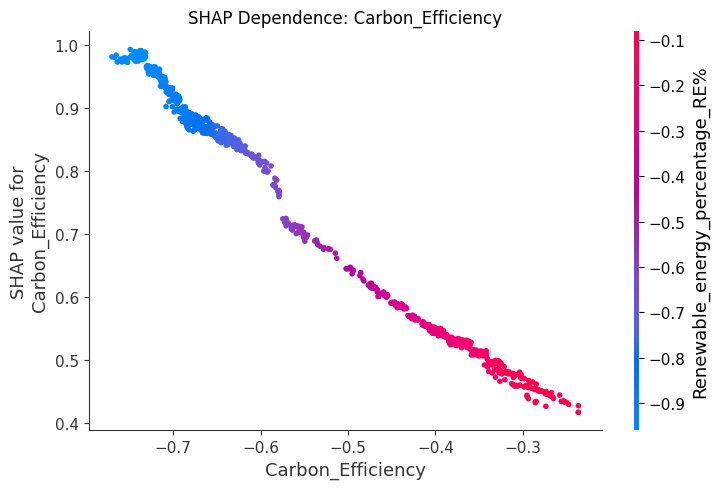

In [10]:
# SHAP Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. SHAP Summary Plot
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False, max_display=10)
plt.title('SHAP Feature Importance Summary')

# 2. SHAP Bar Plot
plt.subplot(2, 2, 2)
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=feature_cols, show=False, max_display=10)
plt.title('SHAP Feature Importance (Bar)')

# 3. Feature importance comparison
plt.subplot(2, 2, 3)
shap_importance = np.abs(shap_values).mean(0)
xgb_importance = xgb_model.feature_importances_

comparison_df = pd.DataFrame({
    'feature': feature_cols,
    'shap_importance': shap_importance,
    'xgb_importance': xgb_importance
}).sort_values('shap_importance', ascending=False).head(10)

x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['shap_importance'], width, label='SHAP', alpha=0.8)
plt.bar(x + width/2, comparison_df['xgb_importance'], width, label='XGBoost', alpha=0.8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('SHAP vs XGBoost Feature Importance')
plt.xticks(x, comparison_df['feature'], rotation=45)
plt.legend()

# 4. SHAP dependence plot for top feature
plt.subplot(2, 2, 4)
top_feature_idx = np.argmax(shap_importance)
shap.dependence_plot(top_feature_idx, shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title(f'SHAP Dependence: {feature_cols[top_feature_idx]}')

plt.tight_layout()
plt.show()

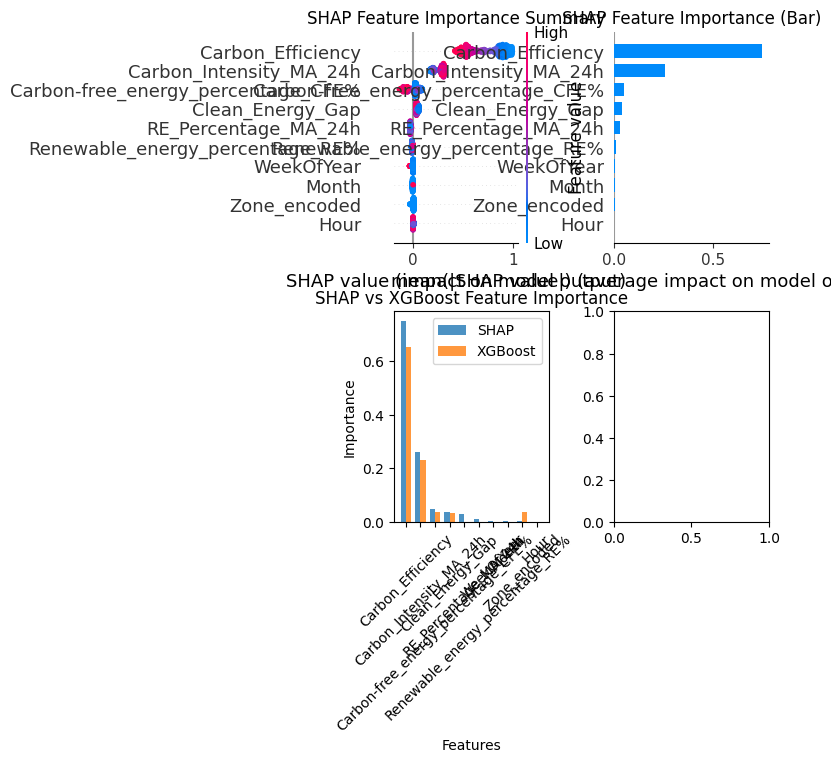

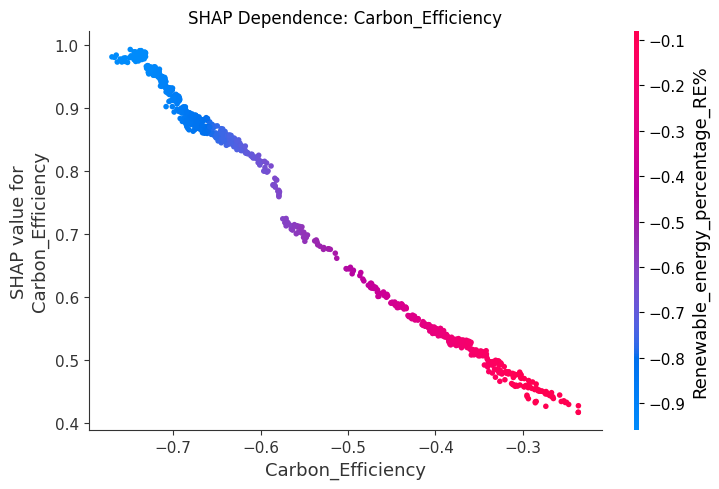

In [11]:
# SHAP Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. SHAP Summary Plot
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False, max_display=10)
plt.title('SHAP Feature Importance Summary')

# 2. SHAP Bar Plot
plt.subplot(2, 2, 2)
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=feature_cols, show=False, max_display=10)
plt.title('SHAP Feature Importance (Bar)')

# 3. Feature importance comparison
plt.subplot(2, 2, 3)
shap_importance = np.abs(shap_values).mean(0)
xgb_importance = xgb_model.feature_importances_

comparison_df = pd.DataFrame({
    'feature': feature_cols,
    'shap_importance': shap_importance,
    'xgb_importance': xgb_importance
}).sort_values('shap_importance', ascending=False).head(10)

x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['shap_importance'], width, label='SHAP', alpha=0.8)
plt.bar(x + width/2, comparison_df['xgb_importance'], width, label='XGBoost', alpha=0.8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('SHAP vs XGBoost Feature Importance')
plt.xticks(x, comparison_df['feature'], rotation=45)
plt.legend()

# 4. SHAP dependence plot for top feature
plt.subplot(2, 2, 4)
top_feature_idx = np.argmax(shap_importance)
shap.dependence_plot(top_feature_idx, shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title(f'SHAP Dependence: {feature_cols[top_feature_idx]}')

plt.tight_layout()
plt.show()

Comparision with Linear Regression model 

In [18]:
# Model Comparison with Linear Regression (if available)
import os
import json

try:
    # Load linear regression results for comparison (use json.load, not joblib.load!)
    if os.path.exists('linear_regression_summary.json'):
        with open('linear_regression_summary.json', 'r') as f:
            lr_summary = json.load(f)
    else:
        lr_summary = None
    
    if lr_summary:
        comparison_df = pd.DataFrame({
            'Model': ['Linear Regression', 'XGBoost'],
            'MAE': [lr_summary['test_metrics']['MAE'], test_mae],
            'RMSE': [lr_summary['test_metrics']['RMSE'], test_rmse],
            'R²': [lr_summary['test_metrics']['R²'], test_r2]
        })
        
        print("\n" + "="*60)
        print("📈 MODEL COMPARISON")
        print("="*60)
        print(comparison_df.round(4))
        
        # Improvement calculation
        mae_improvement = ((lr_summary['test_metrics']['MAE'] - test_mae) / lr_summary['test_metrics']['MAE']) * 100
        rmse_improvement = ((lr_summary['test_metrics']['RMSE'] - test_rmse) / lr_summary['test_metrics']['RMSE']) * 100
        r2_improvement = ((test_r2 - lr_summary['test_metrics']['R²']) / lr_summary['test_metrics']['R²']) * 100
        
        print(f"\n🚀 XGBoost Improvements over Linear Regression:")
        print(f"  MAE improvement: {mae_improvement:.2f}%")
        print(f"  RMSE improvement: {rmse_improvement:.2f}%")
        print(f"  R² improvement: {r2_improvement:.2f}%")
        
    else:
        print("\n⚠️ Linear regression summary file not found")
        
except Exception as e:
    print(f"\n⚠️ Error loading linear regression results: {e}")
    print("Make sure you've run the linear regression model first!")


📈 MODEL COMPARISON
               Model     MAE    RMSE      R²
0  Linear Regression  0.0578  0.0606  0.9735
1            XGBoost  0.0518  0.0606  0.9735

🚀 XGBoost Improvements over Linear Regression:
  MAE improvement: 10.41%
  RMSE improvement: 0.04%
  R² improvement: 0.00%


In [15]:
# Save XGBoost model and comprehensive results
print("💾 Saving XGBoost model and results...")

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')

# Save comprehensive results
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_test,
    'residuals': residuals,
    'abs_error': np.abs(residuals)
})

# Add datetime and zone info
if 'Datetime_UTC' in df.columns:
    results_df['datetime'] = df['Datetime_UTC'].iloc[X_test.index].values
if 'Zone_name' in df.columns:
    results_df['zone'] = df['Zone_name'].iloc[X_test.index].values

results_df.to_csv('xgboost_results.csv', index=False)

# Create SHAP importance DataFrame (this was missing!)
shap_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'SHAP_Importance': np.abs(shap_values).mean(0)
}).sort_values('SHAP_Importance', ascending=False)

# Save model summary
model_summary = {
    'model_type': 'XGBoost Regressor',
    'model_params': xgb_model.get_params(),
    'target_variable': 'Carbon_intensity_gCO₂eq_kWh_direct',
    'features_used': feature_cols,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'test_metrics': {
        'MAE': float(test_mae),
        'RMSE': float(test_rmse),
        'R²': float(test_r2)
    },
    'feature_importance': importance_df.to_dict('records'),
    'shap_importance': shap_importance_df.to_dict('records')
}

import json
with open('xgboost_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

# Save SHAP values for future analysis
np.save('xgboost_shap_values.npy', shap_values)
X_sample.to_csv('xgboost_shap_samples.csv', index=False)

print("✅ XGBoost model saved as 'xgboost_model.pkl'")
print("✅ Results saved as 'xgboost_results.csv'")
print("✅ Summary saved as 'xgboost_summary.json'")
print("✅ SHAP values saved for future analysis")

💾 Saving XGBoost model and results...
✅ XGBoost model saved as 'xgboost_model.pkl'
✅ Results saved as 'xgboost_results.csv'
✅ Summary saved as 'xgboost_summary.json'
✅ SHAP values saved for future analysis
